In [2]:
import os
import cv2
import shutil
from glob import glob
from tqdm import tqdm
import numpy as np

import pandas as pd

from subprocess import call
from urllib.request import urlretrieve

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, inception_v3

# %matplotlib inline

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# # del drive

In [5]:
train = 'G:/Python Data Science/Data/CNN/Fruits/dataset/train'
classes_tr = os.listdir(train)
# classes
data_dict = {}
for class_ in classes_tr:
  # print(f'Class : {class_}........#files : {len(os.listdir(os.path.join(src,class_)))}')
  data_dict[class_] = len(os.listdir(os.path.join(train,class_)))

data_items = list(data_dict.items())
data_items = sorted(data_items, key = lambda x : x[-1])
data_dict = dict(data_items)
data_dict

{'freshoranges': 1466,
 'freshbanana': 1581,
 'rottenoranges': 1595,
 'freshapples': 1693,
 'rottenbanana': 2224,
 'rottenapples': 2342}

In [6]:
test = 'G:/Python Data Science/Data/CNN/Fruits/dataset/test'
classes_ts = os.listdir(test)
# classes
data_dict = {}
for class_ in classes_ts:
  # print(f'Class : {class_}........#files : {len(os.listdir(os.path.join(src,class_)))}')
  data_dict[class_] = len(os.listdir(os.path.join(test,class_)))

data_items = list(data_dict.items())
data_items = sorted(data_items, key = lambda x : x[-1])
data_dict = dict(data_items)
data_dict

{'freshbanana': 381,
 'freshoranges': 388,
 'freshapples': 395,
 'rottenoranges': 403,
 'rottenbanana': 530,
 'rottenapples': 601}

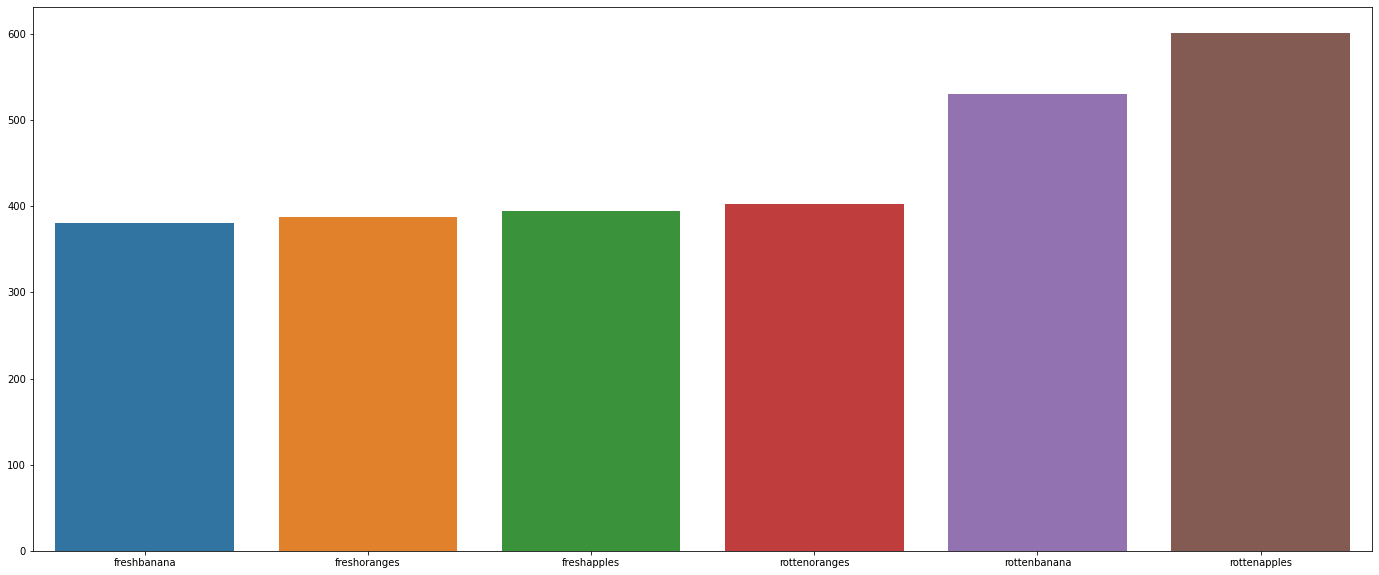

In [7]:
plt.figure(figsize = (24,10))
sns.barplot(x = list(data_dict.keys()), y = list(data_dict.values()))
plt.show()

In [8]:
# Setting up the config
BATCH_SIZE = 32
TARGET_SIZE = (256,256)

In [9]:
# Augmenting the training data

# Note: class_mode = 'binary', 'categorical', 'sparse_categorical'
# Note : save_to_dir would take in a path where it would save all the augmented data while training : makes the training slow

train_data_gen = ImageDataGenerator(rescale = 1./255.,
                                    zoom_range = 0.2,
                                    shear_range = 0.2,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    brightness_range = (0.2,0.4))

train_data = train_data_gen.flow_from_directory(directory = train,
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'categorical',
                                                target_size = TARGET_SIZE)

Found 10901 images belonging to 6 classes.


In [10]:
# Augmenting the test data
test_data_gen = ImageDataGenerator(rescale = 1./255.)

test_data = test_data_gen.flow_from_directory(directory = test,
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'categorical',
                                                target_size = TARGET_SIZE)

Found 2698 images belonging to 6 classes.


In [11]:
batch=train_data.next()
batch[0].shape

(32, 256, 256, 3)

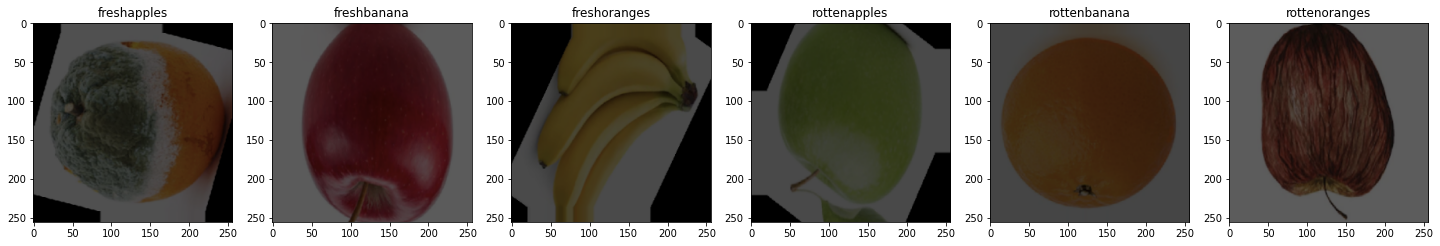

In [12]:
fig,ax=plt.subplots(ncols=6,figsize=(25,25))
for idx,img in enumerate(batch[0][12:18]):
    ax[idx].imshow(img)
    y=classes_ts[idx]
    ax[idx].title.set_text(y)
    # print()
    # ax[idx].imshow(img)
    # ax[idx].title.set_text(batch[1][idx])

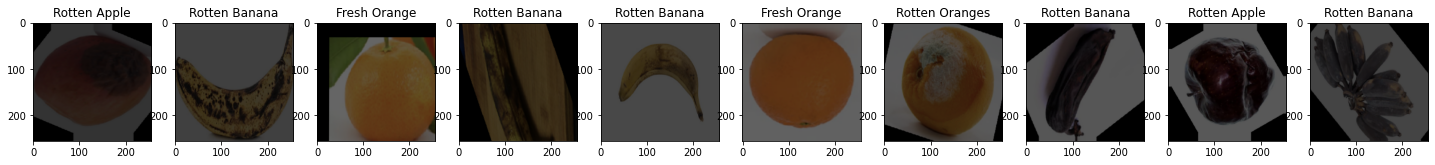

In [13]:
fig,ax=plt.subplots(ncols=10,figsize=(25,25))
for idx,img in enumerate(batch[0][:10]):
    ax[idx].imshow(img)
    index=batch[1][idx]
    
    if index[5]==1:
      name='Rotten Oranges'
    elif index[3]==1:
      name='Rotten Apple'
    elif index[4]==1:
      name='Rotten Banana'
    elif index[2]==1:
      name='Fresh Orange'
    elif index[0]==1:
      name='Fresh Apple'
    elif index[1]==1:
      name='Fresh Banana'
    
    ax[idx].title.set_text(name)

        

In [14]:
# rotten_oranges=[0 0 0 0 0 1]
# rotten_apples= [0 0 0 1 0 0]
# rotten_banana= [0 0 0 0 1 0]
# fresh_oranges= [0 0 1 0 0 0]
# fresh_apple=   [1 0 0 0 0 0]
# fresh_banana=  [0 1 0 0 0 0]


# Model building

In [15]:
# Instantiating the model
cnn = tf.keras.Sequential()

# Adding the input layer
cnn.add(tf.keras.layers.Input(shape = TARGET_SIZE.__add__((3,))))

# Adding the first conv layer
cnn.add(tf.keras.layers.Conv2D(filters = 16,
                               kernel_size = (3,3),
                               padding = 'same',
                               activation = 'relu',
                               kernel_initializer = 'he_uniform'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Adding the second conv layer
cnn.add(tf.keras.layers.Conv2D(filters = 32,
                               kernel_size = (3,3),
                               padding = 'same',
                               activation = 'relu',
                               kernel_initializer = 'he_uniform'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Adding the third conv layer
cnn.add(tf.keras.layers.Conv2D(filters = 32,
                               kernel_size = (3,3),
                               padding = 'same',
                               activation = 'relu',
                               kernel_initializer = 'he_uniform'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))
# Adding dropout
cnn.add(tf.keras.layers.Dropout(rate = 0.2))

# Adding the flattening layer
cnn.add(tf.keras.layers.Flatten())
# Adding dropout
cnn.add(tf.keras.layers.Dropout(rate = 0.4))

# Adding the fully connected layer -> ANN
cnn.add(tf.keras.layers.Dense(units = 1024,
                              activation = 'relu',
                              kernel_initializer = 'he_uniform'))
# Adding dropout
cnn.add(tf.keras.layers.Dropout(rate = 0.3))

cnn.add(tf.keras.layers.Dense(units = 512,
                              activation = 'relu',
                              kernel_initializer = 'he_uniform'))
# Adding dropout
cnn.add(tf.keras.layers.Dropout(rate = 0.2))

cnn.add(tf.keras.layers.Dense(units = len(classes_tr), 
                              activation = 'softmax',
                              kernel_initializer = 'glorot_uniform'))

# Compiling the model
cnn.compile(optimizer = 'adam',
            loss = 'binary_crossentropy',
            metrics = ['accuracy','Recall'])

In [16]:
# Summarizing the model -> No Dropout
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0

In [ ]:

# Learning
history_object = cnn.fit(train_data,
                         epochs = 30,
                         batch_size = BATCH_SIZE,
                         validation_data = test_data,
                         validation_batch_size = BATCH_SIZE,
                         use_multiprocessing = True,
                         workers = 30)

Epoch 1/30


Exception in thread Thread-28 (_run):
Traceback (most recent call last):
  File "C:\Users\HPWorld\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "C:\Users\HPWorld\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\HPWorld\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\data_utils.py", line 759, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "C:\Users\HPWorld\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\data_utils.py", line 736, in pool_fn
    pool = get_pool_class(True)(
  File "C:\Users\HPWorld\AppData\Local\Programs\Python\Python310\lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "C:\Users\HPWorld\AppData\Local\Programs\Python\Python310\lib\multiprocessing\pool.py", line 212, 

In [ ]:
cnn.save("CNN_Fruit_Classification.h5")

NameError: ignored

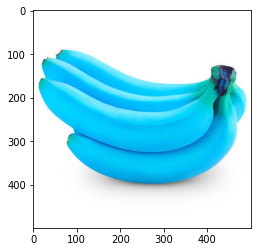

In [ ]:
image_path = 'banana1.jpeg'
image_matrix = cv2.imread(image_path)
plt.imshow(image_matrix)

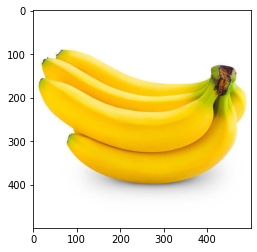

In [ ]:
converted_image = cv2.cvtColor(image_matrix, cv2.COLOR_RGB2BGR)
plt.imshow(converted_image)

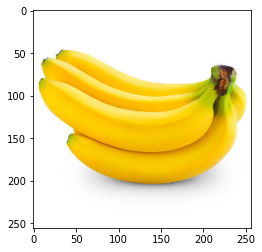

In [ ]:
 resize=tf.image.resize(converted_image,(256,256,))
 plt.imshow(resize.numpy().astype(int))
 plt.show()

In [ ]:

yhat=cnn.predict(np.expand_dims(resize/255,0))
yhat

array([[1.2130251e-15, 9.9999821e-01, 6.7938392e-14, 2.2442327e-10,
        1.7807572e-06, 1.5453906e-10]], dtype=float32)

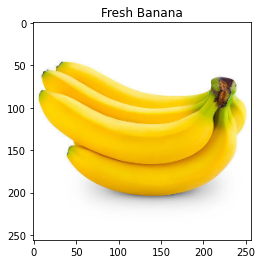

In [ ]:
# fig.ax=plt.subplots(ncols=1,figsize=(5,5))
# for idx,img in/ enumerate(yhat):
# plt.title("abcd")
# plt.imshow(resize.numpy().astype(int))
# plt.show()

index=yhat[0]
    
if index[5]>=0.5:
  name='Rotten Oranges'
elif index[3]>=0.5:
  name='Rotten Apple'
elif index[4]>=0.5:
  name='Rotten Banana'
elif index[2]>=0.5:
  name='Fresh Orange'
elif index[0]>=0.5:
  name='Fresh Apple'
elif index[1]>=0.5:
  name='Fresh Banana'

plt.title(name)
plt.imshow(resize.numpy().astype(int))
plt.show()
# ax[idx].title.set_text(name)

In [ ]:
# fig.ax=plt.subplots(ncols=1,figsize=(5,5))
# for idx,img in/ enumerate(yhat):
# plt.title("abcd")
# plt.imshow(resize.numpy().astype(int))
# plt.show()
from tensorflow.keras.models import load_model
new_model=load_model('G:\Python Data Science\Projects\Apple_CNN\CNN_Fruit_Classification.h5')
image_path = 'G:\Python Data Science\Projects\Apple_CNN\apple1.png'
image_matrix = cv2.imread(image_path)
converted_image = cv2.cvtColor(image_matrix, cv2.COLOR_RGB2BGR)
resize=tf.image.resize(converted_image,(256,256,))
new_yhat=new_model.predict(np.expand_dims(resize/255,0))
new_yhat
index=yhat[0]
    
if index[5]>=0.5:
  name='Rotten Oranges'
elif index[3]>=0.5:
  name='Rotten Apple'
elif index[4]>=0.5:
  name='Rotten Banana'
elif index[2]>=0.5:
  name='Fresh Orange'
elif index[0]>=0.5:
  name='Fresh Apple'
elif index[1]>=0.5:
  name='Fresh Banana'

plt.title(name)
plt.imshow(resize.numpy().astype(int))
plt.show()
# ax[idx].title.set_text(name)